In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import math

from zmq.ssh.tunnel import open_tunnel

#### 1.多头注意力机制
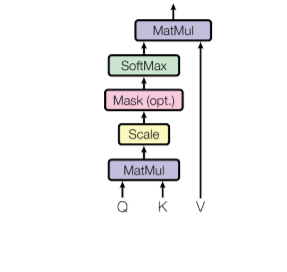
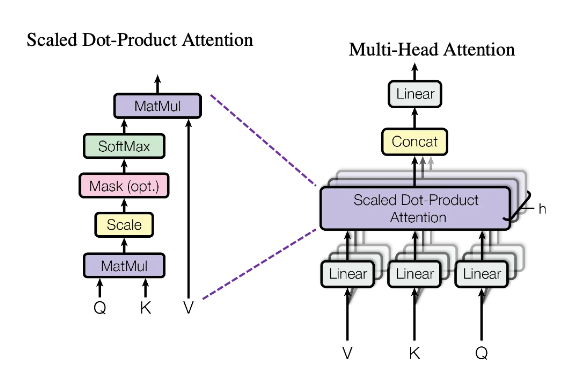
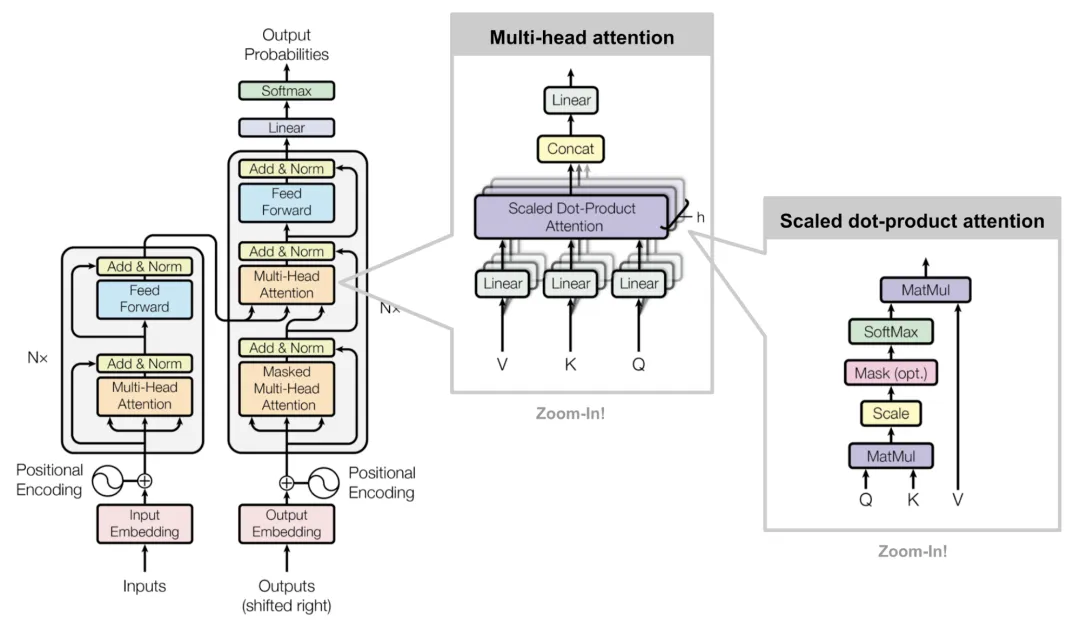
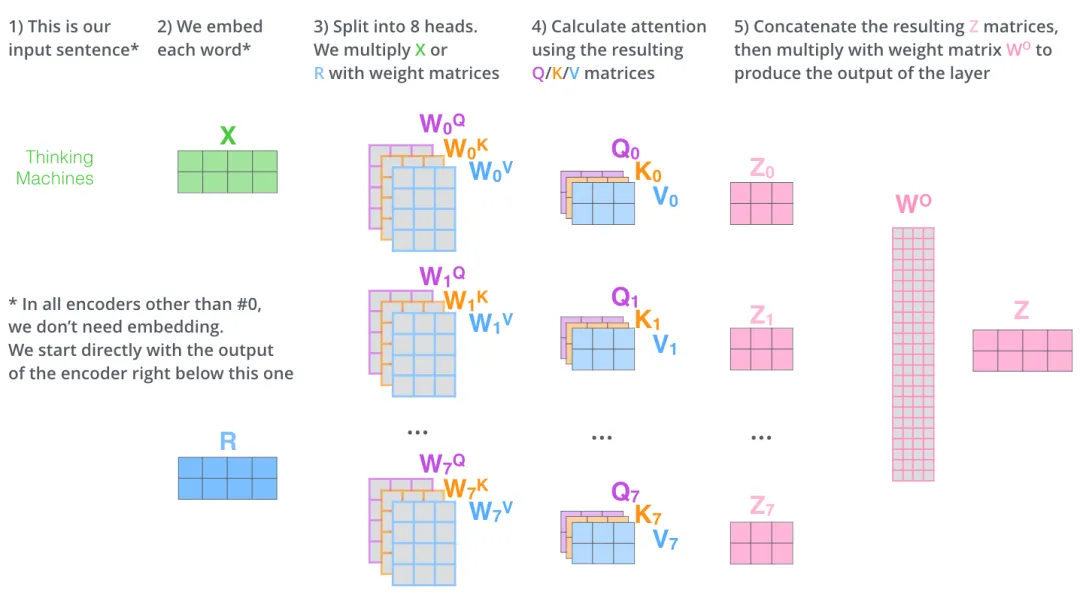

![image.png](attachment:5b335b7d-52d5-4951-8cef-294b1d19aef9.png)

![image.png](attachment:08b30442-28b0-492c-a27e-f790792fef8f.png)

![image.png](attachment:dd7d0e80-f800-4da8-b9cb-167ba0d21170.png)

$
Q = X W^Q, \quad K = X W^K, \quad V = X W^V
$

$
Q_i = X W_i^Q, \quad K_i = X W_i^K, \quad V_i = X W_i^V
$

$W^Q \in \mathbb{R}^{d_{model} \times d_k}$

$W^K \in \mathbb{R}^{d_{model} \times d_k}$

$W^V \in \mathbb{R}^{d_{model} \times d_v}$

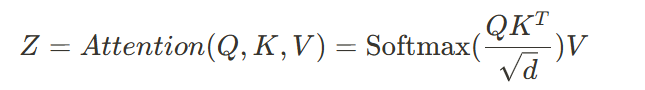

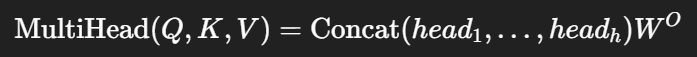

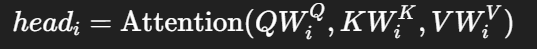

In [2]:
# 多头注意力机制
class MutiHeadAttention(nn.Module):
    def __init__(self,d_model,n_head):
        super().__init__()
        self.n_head=n_head
        self.d_model=d_model
        self.d_k=self.d_model//self.n_head
        self.w_q=nn.Linear(d_model,d_model)
        self.w_k=nn.Linear(d_model,d_model)
        self.w_v=nn.Linear(d_model,d_model)
        self.w_combine=nn.Linear(d_model,d_model)
        self.softmax=nn.Softmax(dim=-1) # nn.Softmax的作用是对矩阵做softmax，dim=1是表示跨列做softmax，dim=0表示跨行做softmax
    def attention(self,q:torch.Tensor,k:torch.Tensor,v:torch.Tensor,mask=None):
        # 输入的q,k,v的大小一般是（batch_size, seq_len, d_model）
        # 构建attention(Q,K,V)
        scores=torch.matmul(q,k.transpose(-1,-2))/math.sqrt(self.d_k)
        # scores维度为(batch_size,seq_len,seq_len)
        if mask is not None:
            # 将scores中位置与mask张量里面等于0位置相同的值转化value
            scores=scores.masked_fill(mask==0,value=-1e9)
        # 对张量进softmax
        scores=self.softmax(scores)
        out=torch.matmul(scores,v)
        # out维度为(batch_size,seq_len,d_model)
        return out
    def forward(self,q:torch.Tensor,k:torch.Tensor,v:torch.Tensor,mask:bool=None):
        batch_size=q.size(0)
        q=self.w_q(q).view(batch_size,-1,self.n_head,self.d_k).transpose(1,2)
        k=self.w_k(k).view(batch_size,-1,self.n_head,self.d_k).transpose(1,2)
        v=self.w_v(v).view(batch_size,-1,self.n_head,self.d_k).transpose(1,2)
        # 此时q,k,v的大小为(batch_size,seq_len,n_head,d_k)->(batch_size,n_head,seq_len,d_k)
        scores=self.attention(q,k,v,mask=mask)
        # scores维度是(batch_size, n_head, seq_len, d_k)
        concat=scores.transpose(1,2).contiguous().view(batch_size,-1,self.d_model)
        # concat的维度是(batch_size,seq_len,d_model)
        output=self.w_combine(concat)
        # out维度是(batch_size,seq_len,d_model)
        return output

In [13]:
test=torch.arange(0,32,dtype=torch.float32).reshape(2,4,4)
muti_head_attention=MutiHeadAttention(4,2)
output=muti_head_attention(test,test,test)
output

tensor([[[ 1.0175,  0.6762, -1.2309, -0.5870],
         [ 0.9599,  0.6436, -1.1721, -0.5576],
         [ 0.9552,  0.6412, -1.1676, -0.5555],
         [ 0.9548,  0.6410, -1.1672, -0.5553]],

        [[ 8.7448,  5.8001, -9.7112, -5.2960],
         [ 8.7448,  5.8001, -9.7112, -5.2959],
         [ 8.7448,  5.8001, -9.7112, -5.2959],
         [ 8.7448,  5.8001, -9.7112, -5.2959]]], grad_fn=<ViewBackward0>)